Installing packages:
```
# polara
pip install --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara
```

In [1]:
from typing import Optional, Union

import numpy as np
import pandas as pd
from polara import get_movielens_data

import seaborn as sns # for better visual aesthetics
sns.set_theme(style='white', context='paper')
%config InlineBackend.figure_format = "svg"

# Task

Develop a recommender systems framework for conducting the necessary experiments, which includes:
- training recsys models
- generating recommendations
- evaluating recommendations quality
- performing model comparison

## Experiment protocol can be described in terms of 4 functions:

```python
# building/training a recommender model
model_params = build_func(model_config, trainset, trainset_description)

# predicting relevance scores for test user-item pairs
model_scores = score_func(model_params, testset, testset_description)

# generating top-n recommendations using predcted scores
model_recoms = recom_func(model_scores, topn)

# evaluating quality of recommendations
recs_quality = evaluate_func(model_recoms, holdout, holdout_description)
```


**Essentially, this is the main functionality provided by most of the recommender systems frameworks.**  
That's why we can say that we're building a simple recsys framework from scratch.

# Preparing Data

We will work with Movielens data again. In this example we take a small dataset with 1 million ratings.  
The `get_movielens_data` function can automatically download it for us. Alternatively, you can manually [download the ML-1M](https://grouplens.org/datasets/movielens/) dataset and provide a local path to it as the first argument.  
The output is a `pandas.DataFrame` object(s). 

In [2]:
data, genres_info = get_movielens_data(
    get_genres=True, # get genre information in addition to ratings
    split_genres=False,
    include_time=True
)

In [3]:
data.head()

,userid,movieid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
movies = genres_info.set_index('movieid')
movies.head()

,movienm,genres
movieid,,
1,Toy Story (1995),Animation|Children's|Comedy
2,Jumanji (1995),Adventure|Children's|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama
5,Father of the Bride Part II (1995),Comedy


In [5]:
data.apply('nunique')

userid         6040
movieid        3706
rating            5
timestamp    458455
dtype: int64

## Visualizing data

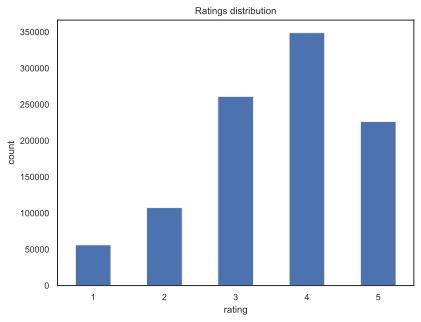

In [6]:
(
    data["rating"]
    .value_counts()
    .sort_index()
    .plot.bar(
        title='Ratings distribution',
        xlabel='rating', ylabel='count',
        rot=0
    )
);

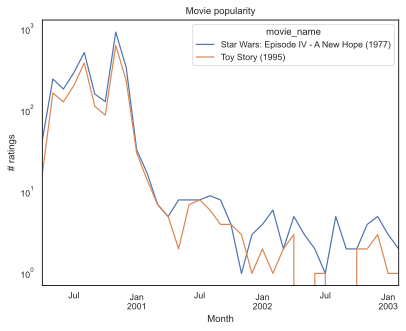

In [7]:
(
    data
    .set_index(pd.to_datetime(data['timestamp'], unit='s')) # use TS as data index
    .query('movieid in [1, 260]') # select movies
    .assign(movie_name=lambda x: x['movieid'].map(movies['movienm'])) # get movie names
    .groupby('movie_name')
    .resample('M') # aggregate number of ratings by month for each movie
    .size() # total count
    .unstack(level=0)
    .plot(logy=True, title='Movie popularity', xlabel='Month', ylabel='# ratings')
);

Let's also see ratings distribution by genre.

In [8]:
movie_genres = movies["genres"].str.split('|') # get a list of genres for each movie
# gather and group all movies per each genre
genre_movies = movie_genres.explode().to_frame().groupby('genres').groups

genre_ratings = {}
for genre, movie_list in genre_movies.items():
    # caculate average rating per genre
    genre_ratings[genre] = (
        data
        .query('movieid in @movie_list')
        .groupby('movieid')["rating"]
        .mean()
    )

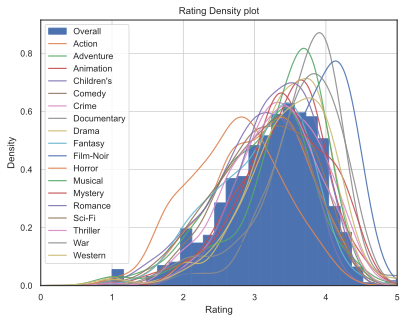

In [9]:
# plot average movie rating distribution
ratings_hist = data.groupby('movieid')['rating'].mean()
ax = ratings_hist.hist(
    bins=25, grid=False, edgecolor='b', density=True, label ='Overall'
)

# plot average movie rating distribution per genre
for genre, rating_dist in genre_ratings.items():
    rating_dist.plot(grid=True, alpha=0.9, kind='kde', label=genre, ax=ax)

ax.legend()
ax.set_xlim(0,5)
ax.set_xlabel('Rating')
ax.set_title('Rating Density plot');

# Preprocess data

Here, we'll use a simple temporal "leave-last-out" scheme for holdout sampling.  
Note that this scheme is not perfect as it's prone to test data leakage from future interactions.

## Data split (leaky but simple)

In [9]:
def leave_last_out(data, userid='userid', timeid='timestamp'):
    data_sorted = data.sort_values(timeid)
    holdout = data_sorted.drop_duplicates(subset=[userid], keep='last') # split the last item from each user's history
    remaining = data.drop(holdout.index) # store the remaining data - will be our training
    return remaining, holdout

In [10]:
training_, holdout_ = leave_last_out(data)

In [11]:
# verify correct splitting: holdout item must have later timestamps for any user
holdout_ts = holdout_.set_index('userid')['timestamp']
training_ts = training_.groupby('userid')['timestamp'].max()
assert holdout_ts.ge(training_ts).all()

## Transform index

In practice,  
- source data is not always numeric;
- moreover, user and item ids may contain large gaps.

We fix that by introducing an internal contiguous numeric index.

In [13]:
def transform_indices(data: pd.DataFrame, users: str, items:str, inplace: bool=False):
    '''
    Reindex columns that correspond to users and items index.
    New index is contiguous starting from 0.
    '''
    data_index = {}
    data_codes = {}
    for entity, field in zip(['users', 'items'], [users, items]):
        new_index, data_index[entity] = to_numeric_id(data, field)
        if inplace:
            data.loc[:, field] = new_index
        else:
            data_codes[field] = new_index
    
    if data_codes:
        data = data.assign(**data_codes) # makes a copy of data
    return data, data_index

def to_numeric_id(data: pd.DataFrame, field: str):
    '''
    Get new contiguous index by converting the data field
    into categorical values.
    '''
    idx_data = data[field].astype("category")
    idx = idx_data.cat.codes
    idx_map = idx_data.cat.categories.rename(field)
    return idx, idx_map

In [14]:
training, data_index = transform_indices(training_, 'userid', 'movieid')

In [17]:
training_.tail()

,userid,movieid,rating,timestamp
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648
1000208,6040,1097,4,956715569


In [18]:
training.tail()

,userid,movieid,rating,timestamp
1000204,6039,1019,1,956716541
1000205,6039,1022,5,956704887
1000206,6039,548,5,956704746
1000207,6039,1024,4,956715648
1000208,6039,1025,4,956715569


In [19]:
data_index

{'users': Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
        ...
        6031, 6032, 6033, 6034, 6035, 6036, 6037, 6038, 6039, 6040],
       dtype='int64', name='userid', length=6040),
 'items': Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
        ...
        3943, 3944, 3945, 3946, 3947, 3948, 3949, 3950, 3951, 3952],
       dtype='int64', name='movieid', length=3704)}

In [20]:
data_index['users']

Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
       ...
       6031, 6032, 6033, 6034, 6035, 6036, 6037, 6038, 6039, 6040],
      dtype='int64', name='userid', length=6040)

In [21]:
data_index['items']

Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
       ...
       3943, 3944, 3945, 3946, 3947, 3948, 3949, 3950, 3951, 3952],
      dtype='int64', name='movieid', length=3704)

In [24]:
data_index['items'].get_indexer([1, 3, 5, 1, 100000000, 'a'])

array([ 0,  2,  4,  0, -1, -1], dtype=int64)

The obtained new index can now also be applied to the other parts of the dataset to align them with the training data. Let's implement the corresponding reindexing function.

In [25]:
def reindex_data(
        data: pd.DataFrame,
        data_index: dict,
        entities: Optional[Union[str, list[str]]] = None,
        inplace: bool = False
    ):
    '''
    Reindex provided data with the specified index mapping.
    By default, will take the name of the fields to reindex from `data_index`.
    It is also possible to specify which field to reindex by providing `entities`.
    '''
    if entities is None:
        entities = data_index.keys()
    if isinstance(entities, str): # handle single entity provided as a string
        entities = [entities]
    
    data_codes = {}
    for entity in entities:
        entity_index = data_index[entity]
        field = entity_index.name # extract the field name
        new_index = entity_index.get_indexer(data[field])
        if inplace:
            data.loc[:, field] = new_index # assign new values inplace
        else:
            data_codes[field] = new_index # store new values
    if data_codes:
        data = data.assign(**data_codes) # assign new values by making a copy
    return data

In [26]:
holdout = reindex_data(holdout_, data_index)

In [27]:
holdout.head()

,userid,movieid,rating,timestamp
998335,6033,881,5,956712388
998435,6034,2929,1,956713640
998312,6032,1539,1,956714112
999731,6037,1094,5,956717204
998139,6030,354,4,956718589


## Data consistency check

We need to ensure that holdout doesn't contain entities that are not present in the training data.

In [28]:
holdout.query('movieid<0')

,userid,movieid,rating,timestamp
6448,45,-1,5,977979487
304604,1811,-1,3,1036451763


In [29]:
# filter out all invalid entries
holdout_clean = holdout.query('movieid >= 0')

## Store useful data characteristics for later use.

In [30]:
data_description = dict(
    users = data_index['users'].name, # user field
    items = data_index['items'].name, # item field
    test_users = holdout_clean[data_index['users'].name].values
)

In [31]:
data_description

{'users': 'userid',
 'items': 'movieid',
 'test_users': array([6033, 6034, 6032, ..., 5947, 5311, 4957], dtype=int64)}

In [32]:
len(data_description['test_users'])

6038

# Random recommendations model

In [34]:
def build_random_model(config: dict, trainset: pd.DataFrame, trainset_description: dict):
    itemid = trainset_description['items']
    n_items = trainset[itemid].max() + 1 # assumes that item index is 0-based contiguous
    random_state = np.random.default_rng(config.get('seed', None)) # create random number generators with the specified `seed``
    return n_items, random_state

In [35]:
def random_model_scoring(params: tuple, testset: pd.DataFrame, testset_description: dict):
    n_items, random_state = params
    n_users = len(testset_description['test_users'])
    scores = random_state.random((n_users, n_items))
    return scores

In [36]:
def simple_model_recom_func(scores: np.ndarray, topn: int=10):
    recommendations = np.apply_along_axis(topidx, 1, scores, topn)
    return recommendations


def topidx(a: np.ndarray, topn: int):
    parted = np.argpartition(a, -topn)[-topn:]
    return parted[np.argsort(-a[parted])]

In [37]:
rnd_params = build_random_model({'seed': 99}, training, data_description)
rnd_scores = random_model_scoring(rnd_params, None, data_description)
rnd_recoms = simple_model_recom_func(rnd_scores, topn=10)

<font color=green>  

* What's the shape of `rnd_scores` array?
* What's the shape of `rnd_recoms` array?

</font>

In [39]:
rnd_recoms.shape

(6038, 10)

In [40]:
def display_movies(items_idx):
    # we convert internal index to external representation
    movie_idx = data_index['items'][items_idx]
    return movies.loc[movie_idx]

In [42]:
display_movies(rnd_recoms[100])

,movienm,genres
movieid,,
1471,Boys Life 2 (1997),Drama
3926,Voyage to the Bottom of the Sea (1961),Adventure|Sci-Fi
3019,Drugstore Cowboy (1989),Crime|Drama
496,What Happened Was... (1994),Comedy|Drama|Romance
2772,Detroit Rock City (1999),Comedy
355,"Flintstones, The (1994)",Children's|Comedy
3772,Hatchet For the Honeymoon (Rosso Segno Della F...,Horror
258,"Kid in King Arthur's Court, A (1995)",Adventure|Children's|Comedy|Fantasy|Romance
2269,Indecent Proposal (1993),Drama


# Simple popularity-based model


In [ ]:
def build_popularity_model(config: dict, trainset: pd.DataFrame, trainset_description: dict):
    itemid = trainset_description['items']
    # create Series object with `itemid`` as index and popularity as values
    item_popularity = ...
    return item_popularity

In [ ]:
def popularity_model_scoring(params: tuple, testset: pd.DataFrame, testset_description: dict):
    item_popularity = params
    # fill in popularity scores for each item with indices from 0 to n_items-1
    n_items = item_popularity.index.max() + 1
    popularity_scores = np.zeros(n_items,)
    popularity_scores[...] = ...
    # assign the same scores across all test user
    n_users = len(testset_description['test_users'])
    scores = ...
    return scores

In [ ]:
pop_params = build_popularity_model({}, training, data_description)
pop_scores = popularity_model_scoring(pop_params, None, data_description)
pop_recoms = simple_model_recom_func(pop_scores)

In [ ]:
display_movies(pop_recoms[0])

# Evaluating recommendations quality

We will use **HitRate** (HR) и **Mean Reciprocal Rank** (MRR).  
*Note*: In the case of a single holdout item per user the latter coincides with the Average Reciprocal HitRate (ARHR) and Mean Average Precision (MAP).

$$
\text{HR} = \frac{1}{\text{\# test users}} \sum_{\text{test users}}{hit}, \quad
$$

$$
hit = 
\begin{gather*}
\begin{cases}
  1 & \text{if holdout item in top-$n$ recommendations,}\\    
  0 & \text{otherwise.}
\end{cases}
\end{gather*}
$$

$$
\text{MRR} = \frac{1}{\text{\# test users}} \sum_{\text{test users}}{\frac{1}{\text{hit rank}}}
$$

In [ ]:
# mark correctly predicted items for random recs
rnd_hits_mask = ...

In [ ]:
# calculate HR for the random recs model
rnd_hr = ...
print(f'{rnd_hr=:.4f}')

In [ ]:
# identify positions of the correctly guessed items within recommendations
rnd_hits_rank = ...

In [ ]:
# calculate MRR for the random recs model
n_test_users = len(data_description['test_users'])
rnd_mrr = ...
print(f'{rnd_mrr=:.4f}')

## Evaluation function

In [ ]:
def model_evaluate(recommended_items, holdout, holdout_description, topn=10):
    itemid = holdout_description['items']
    holdout_items = holdout[itemid].values
    assert recommended_items.shape[0] == len(holdout_items)
    hits_mask = recommended_items[:, :topn] == holdout_items.reshape(-1, 1)
    # HR calculation
    hr = np.mean(hits_mask.any(axis=1))
    # MRR calculation
    n_test_users = recommended_items.shape[0]
    hit_rank = np.where(hits_mask)[1] + 1.0
    mrr = np.sum(1 / hit_rank) / n_test_users
    return hr, mrr

In [ ]:
model_evaluate(rnd_recoms, holdout_clean, data_description)

In [ ]:
model_evaluate(pop_recoms, holdout_clean, data_description)

<font color=green>  

* The obtained results are metrics@<...>?
* What is the obvious way of improving the obtained results? Hint: we miss something in our scoring functions.
* How do we get confidence intervals and estimate statistical significance of the results?
* What changes do we need to make in order to assess strong generalization?

</font>

# Baseline predictor models

In [ ]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import gmres

Reminder on the model formulation:

The task is to solve
$$
    \argmin_{\{g_i\},\{f_j\}}\sum_{i,j\in\mathcal{O}}\left(r_{ij}-g_i-f_j\right)^2,
$$
where 
- $\mathcal{O}$ is a set of observations,
- $r_{ij}$ are known rating values,
- $𝑔_𝑖$ is the generosity of user $i$, i.e. tendency to assign higher or lower rating,
- $𝑓_𝑗$ is the favoredness of item $𝑗$, i.e. how likely it’s to be praised or critiqued.

Solution:
- solve for items favoredness:
$$
    \left(D_f-S^\top D_g^{-1}S\right)f = b_f - S^\top D_g^{-1}b_g
$$
- solve for users generosity:
$$
    g = D_g^{-1}\left(b_g-Sf\right)
$$
where
- $S$ - sparsity pattern of the data
- $D_g=\text{diag}(Se)$ – diagonal matrix of row nnz
- $D_f=\text{diag}(𝑆^\top 𝒆)$ – diagonal matrix of column nnz
- $b_g=Re$ – row-aggregated ratings
- $b_f=𝑅^\top 𝒆$ – columns-aggregated ratings


In [ ]:
def build_predictor_model(config: dict, trainset: pd.DataFrame, trainset_description: dict):
    rows = ...
    cols = ...
    vals = ...
    rating_matrix = csr_matrix((vals, (rows, cols)), dtype=np.float64)
    
    Snnz = (rating_matrix > 0).astype(np.float64)
    
    bg = ...
    bf = ...
    dg = ...
    df = ...

    rhs = ...
    def lhs_matvec(vec):
        ...
    
    gmres_matvec = LinearOperator(shape=(len(bf),)*2, matvec=lhs_matvec, dtype=np.float64)
    item_f, ecode = gmres(gmres_matvec, rhs)
    
    user_g = ...
    global_bias = user_g.sum()
    user_g -= global_bias
    return global_bias, user_g, item_f, ecode

def predictor_model_scoring(params: tuple, testset: pd.DataFrame, testset_description: dict):
    ...
    return scores

In [ ]:
bp_params = build_predictor_model({}, training, data_description)
bp_scores = predictor_model_scoring(bp_params, None, data_description)
bp_recoms = simple_model_recom_func(bp_scores)

In [ ]:
model_evaluate(bp_recoms, holdout_clean, data_description)

<font color=green>  

* Explain the obtained results. Why do you see such scores?
* How to improve the scores?

</font>

# Cross-validation example

Installing packages:
```
# ipypb
pip install ipypb
```

In [ ]:
from ipypb import track

Let's assume there's no dependence of user consumption pattern on time (or at least we are not interested in it). In that case, temporal splitting is not necessary and we can switch to e.g. random sampling strategy. 

Our methodology will be:
- random "leave-one-out" sampling for holdout items
- use $k$-fold cross-validation scheme,
- test against strong generalization of models (warm-start scenario).

## CV boilerplate

### data preparation routines

In [ ]:
def leave_one_out(data, data_descirption, seed=None):
    shuffled = data.sample(frac=1, random_state=seed)
    userid = data_descirption['users']
    random_holdout = shuffled.drop_duplicates(subset=[userid], keep='last')
    remaining = data.drop(random_holdout.index)
    return remaining, random_holdout

def train_test_split(test_index, data, data_description, seed, holdout_sampling=None):
    userid = data_description['users']
    itemid = data_description['items']
    if holdout_sampling is None:
        holdout_sampling = leave_one_out # random holdout
    # split train/test and build internal index
    test_data_ = data.iloc[test_index]
    training_ = data.drop(test_data_.index)
    training, data_index = transform_indices(training_, userid, itemid)
    # conform test data with internal index, skip items not present in training
    # note, we do not need to reindex users as they are not part of the training!
    test_data = reindex_data(test_data_, data_index, 'items').query(f'{itemid} >= 0')
    # split holdout
    testset_, holdout_ = holdout_sampling(test_data, data_description, seed=seed)
    # ensure user index consistency in test data
    # due to warm-start condition, we don't need to check
    # for consistency with the training data
    same_test_users = testset_[userid].isin(holdout_[userid])
    if not same_test_users.all():
        testset_ = testset_[same_test_users]
    # sort by users for convenience and conformity
    testset = testset_.sort_values(userid)
    holdout = holdout_.sort_values(userid)
    return training, testset, holdout, data_index

### CV routines

In [ ]:
from sklearn.model_selection import GroupKFold

In [ ]:
metrics = ['HR', 'MRR']

In [ ]:
def run_kfold_cv(
    data, data_description,
    models, configs,
    build_funcs, score_funcs,
    recom_func, eval_func,
    *,
    k_folds=5,
    topn_list=None,
    seed=None,
    fold_experiment=None,
    **kwargs
): 
    # perform basic checks
    assert len(configs) == len(models) == len(build_funcs) == len(score_funcs)
    if fold_experiment is None:
        fold_experiment = run_fold_experiment
    if topn_list is None:
        topn_list = [10]
    # initiate experiment
    kfold = GroupKFold(n_splits=k_folds)
    user_groups = data[data_description['users']]
    results = []
    for train_idx, test_idx in track(kfold.split(data, groups=user_groups), k_folds):
        fold_data = train_test_split(test_idx, data, data_description, seed)
        fold_res = fold_experiment(
            fold_data, data_description,
            models, configs,
            build_funcs, score_funcs,
            recom_func, eval_func,
            topn_list,
            **kwargs
        )
        results.append(fold_res)
    return results


def run_fold_experiment(
    fold_data, data_description,
    models,  configs,
    build_funcs, score_funcs,
    recom_func, eval_func,
    topn_list
):
    fold_results = {model: {metric: [] for metric in metrics} for model in models}
    topn_max = max(topn_list)
    # unpack experiment data
    training, testset, holdout, data_index = fold_data
    testset_description = {
        **data_description,
        'n_test_users': testset[data_description['users']].nunique()
    }
    # run experiment
    for model, build_func, score_func, model_config in zip(models, build_funcs, score_funcs, configs):
        model_params = ...
        model_scores = ...
        model_recoms = ...
        for topn in topn_list:
            hr, mrr = eval_func(model_recoms, holdout, data_description, topn=topn)
            fold_results[model]['HR'].append(hr)
            fold_results[model]['MRR'].append(mrr)
    return fold_results

Quick reminder on functions signatures:
```python
pop_params = build_popularity_model({}, training, data_description)
pop_scores = popularity_model_scoring(pop_params, None, data_description)
pop_recoms = simple_model_recom_func(pop_scores)
```

## run experiment

In [ ]:
model_names = ['most popular', 'random']
model_configs = [{}, {'seed': 0}]
model_build_funcs = [build_popularity_model, build_random_model]
models_scoring = [popularity_model_scoring, random_model_scoring]
topn_list = [1, 5, 10]

results = run_kfold_cv(
    data, data_description,
    model_names, model_configs,
    model_build_funcs, models_scoring,
    simple_model_recom_func, model_evaluate,
    k_folds=4, topn_list=topn_list
)

In [ ]:
len(results)

# Results analysis

In [ ]:
def results_to_df(results, topn_list):
    metric_index = pd.MultiIndex.from_product(
        [metrics, topn_list],
        names=['metric', 'topn']
    )
    results_df = pd.concat(
        {
            foldid: pd.DataFrame(res)
            .explode(column=list(res.keys()))
            .set_index(metric_index)
            for foldid, res in enumerate(results, start=1)
        },
        names=['fold']
    )
    return results_df

In [ ]:
results_df = results_to_df(results, topn_list)
results_df.head(10)

In [ ]:
results_df.groupby(level=['metric', 'topn']).mean()

In [ ]:
results_df.groupby(level=['metric', 'topn']).std()

<font color=green>

- Do we actually measure user satisfaction with the implemented sampling? Why?
- Suggest an evaluation protocol to measure potential satisfaction better.

</font>

# Extra

## Significance test

In [ ]:
from polara.evaluation.evaluation_engine import sample_ci

In [ ]:
sample_ci(results_df.unstack('metric'), level='topn')

## Using Polara

In [ ]:
from polara import RecommenderData, RandomModel, PopularityModel

### Most-recent-item split example

In [ ]:
data_config = dict(
    warm_start = False,
    holdout_size = 1,
    test_ratio = 0, # split holdout from all users
    random_holdout = False, # use either feedback or custom_order field
)
dm = RecommenderData(
    data, 'userid', 'movieid', 'rating',
    custom_order='timestamp', config=data_config
)


In [ ]:
print(dm)

In [ ]:
dm.prepare()

In [ ]:
pop = PopularityModel(dm)
pop.build()
pop.evaluate()

In [ ]:
rnd = RandomModel(dm, seed=0)
rnd.build()
rnd.evaluate()

### Cross-validation example

In [ ]:
from polara.evaluation import evaluation_engine as ee

In [ ]:
dm = RecommenderData(data, 'userid', 'movieid', 'rating')

dm.warm_start = True
dm.holdout_size = 1
dm.test_ratio = 0.2 # split holdout from all users
dm.random_holdout = True # sample randomly
dm.verbose = False # don't print data update info

In [ ]:
dm.get_configuration()

In [ ]:
topk_values = [1, 5, 10]
models = [
    RandomModel(dm, seed=0),
    PopularityModel(dm)
]

# run CV experiment
results = ee.run_cv_experiment(
    models,
    fold_experiment=ee.topk_test,
    topk_list=topk_values,
    iterator=track
)

In [ ]:
results.loc[:, :'experience'].groupby(level=['top-n', 'model']).mean()

# Helpers

In [ ]:
def downvote_seen_items(scores, data, data_description):
    itemid = data_description['items']
    userid = data_description['users']
    # get indices of observed data
    data_sorted = data.sort_values(userid)
    item_idx = data_sorted[itemid].values
    user_idx = data_sorted[userid].values
    user_idx = np.r_[False, user_idx[1:] != user_idx[:-1]].cumsum()
    # downvote scores at the corresponding positions
    seen_idx_flat = np.ravel_multi_index((user_idx, item_idx), scores.shape)
    np.put(scores, seen_idx_flat, scores.min() - 1)